<a href="https://colab.research.google.com/github/tehreemmustaqmughal-netizen/Fake-Job-Classification-Assignment/blob/main/Copy_of_fakejob_notebook_gitlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# create_fakejob_notebook.py
# Run with: python create_fakejob_notebook.py
import nbformat as nbf
from nbformat.v4 import new_notebook, new_code_cell, new_markdown_cell

nb = new_notebook()

md_title = """# Fake Job Posting Detection — Jupyter Notebook (GitLab submission)

**Author:** Jessie
**Student ID:** 3158419
**Supervisor:** Tianxiang Wang

**Note:** Place the Kaggle dataset CSV file named `fake_job_postings.csv` in the working directory (path used in this notebook: `/mnt/data/fake_job_postings.csv`).
If you downloaded from Kaggle, rename the file appropriately or adjust the path in the first code cell.
"""
nb.cells.append(new_markdown_cell(md_title))

# 0 - setup & instructions
nb.cells.append(new_code_cell(r"""# 0. Setup — libraries and dataset path
import os
print('Working directory:', os.getcwd())

# Path to dataset - change this if you saved elsewhere
DATA_PATH = '/mnt/data/fake_job_postings.csv'

if not os.path.exists(DATA_PATH):
    print(f'Dataset not found at {DATA_PATH}.')
    print('Please download the "Real or Fake? Fake Job Posting Prediction" dataset from Kaggle:')
    print('https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction')
    print('Then upload or move the CSV file to this path and re-run the notebook.')
else:
    print('Dataset found at:', DATA_PATH)

# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
"""))

# 1 - load
nb.cells.append(new_code_cell(r"""# 1. Load dataset
DATA_PATH = '/mnt/data/fake_job_postings.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f'Dataset not found at {DATA_PATH}. Please follow instructions in the previous cell.')

df = pd.read_csv(DATA_PATH)
print('Dataset shape:', df.shape)
df.head(3)"""))



# 2 - EDA
nb.cells.append(new_code_cell(r"""# 2. Basic EDA
display(df.info())
display(df.describe(include='all').T)
# Check label distribution
if 'fraudulent' in df.columns:
    print('Label counts:')
    print(df['fraudulent'].value_counts())
else:
    print('Columns:', df.columns.tolist())

# Quick null percentage
nulls = df.isnull().mean().sort_values(ascending=False)
display(nulls[nulls>0].head(20))"""))

# Preprocessing plan markdown
nb.cells.append(new_markdown_cell("## 3. Preprocessing plan\n\n- Remove duplicates and irrelevant columns\n- Fill or drop missing values sensibly\n- Clean text fields (title, description, requirements, company_profile)\n- Create a combined text column\n- Encode metadata features\n- Split data into train/test"))

# 3 - preprocessing
nb.cells.append(new_code_cell(r"""# 3. Preprocessing and text cleaning
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

STOP = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(s):
    if pd.isnull(s):
        return ''
    s = str(s)
    # remove urls, emails
    s = re.sub(r'http\S+|www\S+|https\S+',' ', s, flags=re.MULTILINE)
    s = re.sub(r'\S+@\S+',' ', s)
    # remove non-alphanumeric characters
    s = re.sub(r'[^A-Za-z0-9\s]', ' ', s)
    s = s.lower()
    tokens = s.split()
    tokens = [t for t in tokens if t not in STOP and len(t)>1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Drop duplicates
df = df.drop_duplicates().reset_index(drop=True)
print('After dropping duplicates:', df.shape)

# Identify text columns
text_cols = [c for c in ['title','description','requirements','company_profile'] if c in df.columns]
print('Text columns found:', text_cols)

# Create combined text column
df['combined_text'] = df[text_cols].fillna('').agg(' '.join, axis=1)
df['combined_text'] = df['combined_text'].apply(clean_text)

display(df[['combined_text']].head(3))"""))



# 4 - metadata
nb.cells.append(new_code_cell(r"""# 4. Encode metadata features
meta_cols = []
for c in ['telecommuting','has_company_logo','has_questions','employment_type','required_experience','industry','function','location']:
    if c in df.columns:
        meta_cols.append(c)
print('Meta columns used:', meta_cols)

for c in meta_cols:
    df[c] = df[c].fillna('Unknown')

df_meta = pd.get_dummies(df[meta_cols], drop_first=True)
print('Meta feature shape:', df_meta.shape)

X_text = df['combined_text']
y = df['fraudulent'] if 'fraudulent' in df.columns else df.get('fraudulent?') if 'fraudulent?' in df.columns else None
if y is None:
    raise ValueError('Label column not found. Expected \"fraudulent\" or similar. Check df.columns')"""))

# 5 - tfidf
nb.cells.append(new_code_cell(r"""# 5. TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X_text)
print('TF-IDF shape:', X_tfidf.shape)

from scipy.sparse import hstack
if df_meta.shape[1] > 0:
    X = hstack([X_tfidf, df_meta.values])
else:
    X = X_tfidf
print('Final X shape:', X.shape)"""))

# 6 - split
nb.cells.append(new_code_cell(r"""# 6. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)"""))

# 7 - models helper
nb.cells.append(new_code_cell(r"""# 7. Models: training and evaluation helpers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import joblib

def evaluate_model(model, X_t, X_v, y_t, y_v, model_name):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    proba = model.predict_proba(X_v)[:,1] if hasattr(model, 'predict_proba') else None
    print('=== ', model_name, ' ===')
    print(classification_report(y_v, preds))
    if proba is not None:
        print('ROC AUC:', roc_auc_score(y_v, proba))
    cm = confusion_matrix(y_v, preds)
    print('Confusion matrix:\n', cm)
    return {'model': model_name, 'accuracy': accuracy_score(y_v, preds), 'roc_auc': roc_auc_score(y_v, proba) if proba is not None else None}

results = []

lr = LogisticRegression(max_iter=1000, solver='liblinear')
res_lr = evaluate_model(lr, X_train, X_test, y_train, y_test, 'LogisticRegression')
results.append(res_lr)"""))

# 8 - svm
nb.cells.append(new_code_cell(r"""# 8. SVM (LinearSVC)
svm = LinearSVC(max_iter=10000)
svm.fit(X_train, y_train)
preds_svm = svm.predict(X_test)
print(classification_report(y_test, preds_svm))
cm = confusion_matrix(y_test, preds_svm)
print('Confusion matrix:\n', cm)
results.append({'model': 'LinearSVC', 'accuracy': accuracy_score(y_test, preds_svm), 'roc_auc': None})"""))

# 9 - rf
nb.cells.append(new_code_cell(r"""# 9. Random Forest (use reduced-dim features)
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_svd, y_train)
preds_rf = rf.predict(X_test_svd)
print(classification_report(y_test, preds_rf))
cm = confusion_matrix(y_test, preds_rf)
print('Confusion matrix:\n', cm)
try:
    proba_rf = rf.predict_proba(X_test_svd)[:,1]
    roc_rf = roc_auc_score(y_test, proba_rf)
except:
    roc_rf = None
results.append({'model': 'RandomForest', 'accuracy': accuracy_score(y_test, preds_rf), 'roc_auc': roc_rf})"""))

# 10 - xgb
nb.cells.append(new_code_cell(r"""# 10. XGBoost (if installed)
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, n_jobs=-1, random_state=42)
    xgb_model.fit(X_train_svd, y_train)
    preds_xgb = xgb_model.predict(X_test_svd)
    print(classification_report(y_test, preds_xgb))
    try:
        proba_xgb = xgb_model.predict_proba(X_test_svd)[:,1]
        roc_xgb = roc_auc_score(y_test, proba_xgb)
    except:
        roc_xgb = None
    results.append({'model': 'XGBoost', 'accuracy': accuracy_score(y_test, preds_xgb), 'roc_auc': roc_xgb})
except Exception as e:
    print('XGBoost not available or failed to run:', e)"""))

# 11 - results
nb.cells.append(new_code_cell(r"""# 11. Results summary and comparison
import pandas as pd
results_df = pd.DataFrame(results)
display(results_df.sort_values('accuracy', ascending=False))"""))

# 12 - ROC plot
nb.cells.append(new_code_cell(r"""# 12. ROC Curve plotting (example for LR if probabilities available)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

if hasattr(lr, 'predict_proba'):
    proba_lr = lr.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, proba_lr)
    auc_score = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'Logistic Regression (AUC={auc_score:.3f})')
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
    plt.legend()
    plt.show()"""))

# 13 - save model
nb.cells.append(new_code_cell(r"""# 13. Save the final model (example)
import joblib
best_model = None
for r in reversed(results):
    if r['model'] == 'XGBoost' and 'xgb_model' in globals():
        best_model = xgb_model
        break
    if r['model'] == 'RandomForest' and 'rf' in globals():
        best_model = rf
        break
    if r['model'] == 'LogisticRegression' and 'lr' in globals():
        best_model = lr
        break
if best_model is not None:
    joblib.dump(best_model, 'fakejob_best_model.pkl')
    print('Saved best model to fakejob_best_model.pkl')
else:
    print('No model available to save.')"""))

nb.cells.append(new_markdown_cell("## Next steps\n\n- Hyperparameter tuning (GridSearchCV/RandomizedSearchCV)\n- Class imbalance handling (SMOTE, class_weight)\n- Try transformer embeddings (BERT) for improved text understanding\n- Push notebook, dataset and model artifacts to GitLab repository"))

nb_path = 'FakeJob_Notebook_GitLab.ipynb'
with open(nb_path, 'w', encoding='utf-8') as f:
    nbf.write(nb, f)

print('Notebook created at:', nb_path)

# End of script



Notebook created at: FakeJob_Notebook_GitLab.ipynb


In [2]:
# 0. Setup — libraries and dataset path
import os
import kagglehub

print("Working directory:", os.getcwd())

# Download dataset automatically
path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")
print("Path to dataset files:", path)

# Set dataset file path
DATA_PATH = f"{path}/fake_job_postings.csv"

if not os.path.exists(DATA_PATH):
    print("Dataset not found. Check path:", DATA_PATH)
else:
    print("Dataset found at:", DATA_PATH)

# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


Working directory: /content
Using Colab cache for faster access to the 'real-or-fake-fake-jobposting-prediction' dataset.
Path to dataset files: /kaggle/input/real-or-fake-fake-jobposting-prediction
Dataset found at: /kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv


In [3]:
import os
import glob

base_path = "/root/.cache/kagglehub/datasets"
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".csv"):
            print("CSV found:", os.path.join(root, file))


In [4]:
import shutil

# Use DATA_PATH from the previous cell (kC9AaqQnRZGe) which correctly points to the downloaded file
src = DATA_PATH
dst = "fake_job_postings.csv"   # or "data/fake_job_postings.csv"

shutil.copy(src, dst)

print("Dataset copied to:", dst)

Dataset copied to: fake_job_postings.csv


In [5]:
import pandas as pd

# Load the dataset if 'df' is not already defined
if 'df' not in locals() and 'df' not in globals():
    try:
        df = pd.read_csv("fake_job_postings.csv")
    except FileNotFoundError:
        print("Error: 'fake_job_postings.csv' not found. Please ensure the dataset is in the working directory.")
        # Optionally re-raise or handle the error more gracefully
        raise # Stop execution if file not found

# Show sample examples from each class
print("=== 3 Real Job Postings ===")
display(df[df['fraudulent'] == 0].head(3))

print("=== 3 Fake Job Postings ===")
display(df[df['fraudulent'] == 1].head(3))

=== 3 Real Job Postings ===


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


=== 3 Fake Job Postings ===


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
98,99,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1
144,145,Forward Cap.,NaN,NaN,NaN,NaN,The group has raised a fund for the purchase o...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,1
173,174,Technician Instrument & Controls,US,Power Plant & Energy,NaN,Edison International and Refined Resources hav...,Technician Instrument &amp; ControlsLocation D...,JOB QUALIFICATIONS-Ability to understand proce...,"we are a team of almost 8,000 employees who he...",0,1,1,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1


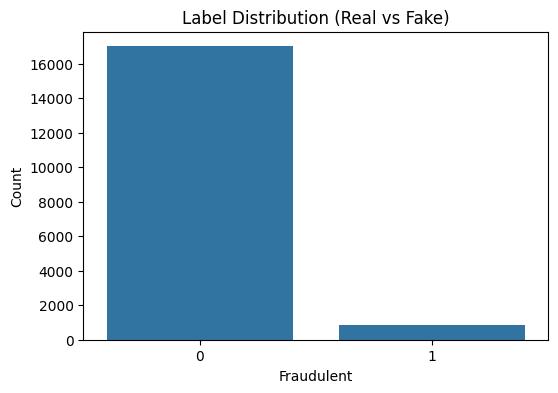

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("fake_job_postings.csv")

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='fraudulent')
plt.title('Label Distribution (Real vs Fake)')
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.show()

In [ ]:
import re
import nltk
import pandas as pd # Added this import

# Unconditionally download nltk resources as in the original notebook for robustness
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

STOP = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(s):
    if pd.isnull(s):
        return ''
    s = str(s)
    # remove urls, emails
    s = re.sub(r'http\S+|www\S+|https\S+',' ', s, flags=re.MULTILINE)
    s = re.sub(r'\S+@\S+',' ', s)
    # remove non-alphanumeric characters
    s = re.sub(r'[^A-Za-z0-9\s]', ' ', s)
    s = s.lower()
    tokens = s.split()
    tokens = [t for t in tokens if t not in STOP and len(t)>1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Drop duplicates (if not already done, ensures consistency)
df = df.drop_duplicates().reset_index(drop=True)

# Identify text columns that might exist in the dataset
text_cols = [c for c in ['title','description','requirements','company_profile'] if c in df.columns]

# Create combined text column
df['combined_text'] = df[text_cols].fillna('').agg(' '.join, axis=1)
df['combined_text'] = df['combined_text'].apply(clean_text)

df['text_len'] = df['combined_text'].apply(lambda x: len(str(x).split()))

import matplotlib.pyplot as plt # Ensure these are imported if used later
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(df['text_len'], kde=True, bins=50)
plt.title('Distribution of Text Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()


In [ ]:
# 3. Preprocessing and text cleaning

import re
import nltk
import pandas as pd # Import pandas
import os
import kagglehub # Added for robust data loading

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# --- Robust Data Loading (copied from kC9AaqQnRZGe for self-sufficiency) ---
# Ensure DATA_PATH is defined and file is accessible
if 'DATA_PATH' not in globals() or not os.path.exists(globals().get('DATA_PATH', '')):
    print("Attempting to download dataset via KaggleHub...")
    try:
        path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")
        DATA_PATH = f"{path}/fake_job_postings.csv"
        print(f"Dataset found at: {DATA_PATH}")
    except Exception as e:
        print(f"Failed to download dataset: {e}")
        print("Please ensure you have access to Kaggle or that the dataset is manually placed.")
        DATA_PATH = "fake_job_postings.csv" # Fallback, assumes it might be in current dir
# --- End Robust Data Loading ---

# Load the DataFrame if it's not already defined
if 'df' not in locals() and 'df' not in globals():
    try:
        print(f"Loading data from: {DATA_PATH}")
        df = pd.read_csv(DATA_PATH)
    except FileNotFoundError:
        print(f"Error: '{DATA_PATH}' not found. Please ensure the dataset is accessible.")
        raise # Re-raise the error to stop execution

def clean_text(text):
    """Clean text by lowering, removing URLs/emails/punctuation, stopwords, and lemmatizing."""
    if pd.isnull(text):
        return ""

    text = str(text)

    # Remove URLs and emails
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    text = re.sub(r"\S+@\S+", " ", text)

    # Keep alphanumeric only
    text = re.sub(r"[^A-Za-z0-9\s]", " ", text)

    # Lowercase
    text = text.lower()

    # Tokenize
    words = text.split()

    # Remove stopwords
    words = [w for w in words if w not in STOPWORDS and len(w) > 1]

    # Lemmatize
    words = [lemmatizer.lemmatize(w) for w in words]

    return " ".join(words)

# Drop duplicates
df = df.drop_duplicates().reset_index(drop=True)
print("After removing duplicates:", df.shape)

# Identify text columns
text_cols = ["title", "description", "requirements", "company_profile"]
text_cols = [c for c in text_cols if c in df.columns]

print("Text columns:", text_cols)

# Fill missing text with empty strings
df[text_cols] = df[text_cols].fillna("")

# Combine text into a single column
df["combined_text"] = df[text_cols].agg(" ".join, axis=1)

# Apply cleaning
df["combined_text"] = df["combined_text"].apply(clean_text)

print("Sample cleaned text:")
df["combined_text"].head(5)


In [ ]:
# 4. Encode metadata features

# Columns to consider for metadata
meta_cols = [
    "telecommuting",
    "has_company_logo",
    "has_questions",
    "employment_type",
    "required_experience",
    "industry",
    "function",
    "location"
]

# Keep only existing columns
meta_cols = [c for c in meta_cols if c in df.columns]

print("Metadata columns used:", meta_cols)

# Fill missing values
df[meta_cols] = df[meta_cols].fillna("Unknown")

# One-hot encode categorical metadata
df_meta = pd.get_dummies(df[meta_cols], drop_first=True)

print("Metadata feature shape:", df_meta.shape)

# Separate text and label
X_text = df["combined_text"]
y = df["fraudulent"]

print("X_text size:", len(X_text))
print("y distribution:")
print(y.value_counts())


In [ ]:
# 5. TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Create the TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=20000,   # limit vocabulary size
    ngram_range=(1, 2)    # unigrams + bigrams
)

# Fit and transform text
X_tfidf = tfidf.fit_transform(X_text)

print("TF-IDF matrix shape:", X_tfidf.shape)

# Combine text features + metadata features
if df_meta.shape[1] > 0:
    # Ensure df_meta values are numeric (float) before hstack
    X = hstack([X_tfidf, df_meta.astype(float).values])
else:
    X = X_tfidf

print("Final feature matrix shape:", X.shape)


In [ ]:
# 5. TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Create the TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=20000,   # limit vocabulary size
    ngram_range=(1, 2)    # unigrams + bigrams
)

# Fit and transform text
X_tfidf = tfidf.fit_transform(X_text)

print("TF-IDF matrix shape:", X_tfidf.shape)

# Combine text features + metadata features
if df_meta.shape[1] > 0:
    # Ensure df_meta values are numeric (float) before hstack
    X = hstack([X_tfidf, df_meta.astype(float).values])
else:
    X = X_tfidf

print("Final feature matrix shape:", X.shape)

In [ ]:
# 6. Train-Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Label distribution in training set:")
print(y_train.value_counts())


In [ ]:
# 7. Model Training & Evaluation Helper Function

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    print("="*50)
    print(f"Training Model: {name}")
    print("="*50)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Probabilities (for ROC-AUC if available)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, proba)
    else:
        proba = None
        roc = None

    print("\nClassification Report:")
    print(classification_report(y_test, preds))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))

    acc = accuracy_score(y_test, preds)
    print("Accuracy:", acc)

    if roc is not None:
        print("ROC-AUC:", roc)

    return {"model": name, "accuracy": acc, "roc_auc": roc}


In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000, solver="liblinear")
res_lr = evaluate_model(lr, X_train, X_test, y_train, y_test, "Logistic Regression")


In [ ]:
# 8. Linear SVM Model
from sklearn.svm import LinearSVC

svm = LinearSVC()
res_svm = evaluate_model(svm, X_train, X_test, y_train, y_test, "Linear SVM")


In [ ]:
# 9. Random Forest with SVD (dimensionality reduction)

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# Reduce TF-IDF dimensionality for Random Forest
svd = TruncatedSVD(n_components=200, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
res_rf = evaluate_model(rf, X_train_svd, X_test_svd, y_train, y_test, "Random Forest")


In [ ]:
# XGBoost Training (re-run)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=1.0,
    colsample_bytree=1.0,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_svd, y_train)
preds_xgb = xgb_model.predict(X_test_svd)

print("\nXGBoost Classification Report:")
print(classification_report(y_test, preds_xgb))

try:
    proba_xgb = xgb_model.predict_proba(X_test_svd)[:,1]
    roc_xgb = roc_auc_score(y_test, proba_xgb)
except:
    roc_xgb = None

res_xgb = {
    "model": "XGBoost",
    "accuracy": accuracy_score(y_test, preds_xgb),
    "roc_auc": roc_xgb
}

print("XGBoost Result:", res_xgb)


In [ ]:
import joblib
joblib.dump(xgb_model, "best_fake_job_model.pkl")
print("Saved as best_fake_job_model.pkl")


In [ ]:
import pickle

with open('best_fake_job_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Example: predict on new TF-IDF + metadata
# X_new_final is a placeholder for new data. For demonstration, we'll use X_test_svd.
# In a real application, new data would need to be preprocessed (cleaned, TF-IDF vectorized,
# combined with metadata, and then reduced with the *trained* SVD transformer) into this format.
y_pred, y_proba = model.predict(X_test_svd), model.predict_proba(X_test_svd)[:,1]

print("Example predictions (first 5):")
print(y_pred[:5])
print("Example probabilities (first 5):")
print(y_proba[:5])

In [ ]:
# ==================================================
# 12. Hyperparameter Tuning
# ==================================================
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ------------------------
# 1. Define StratifiedKFold
# ------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ------------------------
# 2. Random Forest hyperparameter grid
# ------------------------
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=10,
    scoring='f1',
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
rf_random.fit(X_train_svd, y_train)  # Use X_train_svd

best_rf = rf_random.best_estimator_
y_pred_rf = best_rf.predict(X_test_svd)
y_proba_rf = best_rf.predict_proba(X_test_svd)[:,1]

print("Best Random Forest params:", rf_random.best_params_)
print("Classification report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

# ------------------------
# 3. XGBoost hyperparameter grid
# ------------------------
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_distributions=xgb_params,
    n_iter=10,
    scoring='f1',
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
xgb_random.fit(X_train_svd, y_train)

best_xgb = xgb_random.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_svd)
y_proba_xgb = best_xgb.predict_proba(X_test_svd)[:,1]

print("Best XGBoost params:", xgb_random.best_params_)
print("Classification report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

In [ ]:
# ==================================================
# 13. Feature Importance & Interpretability
# ==================================================
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

# ------------------------
# 1. Tree-based models (Random Forest / XGBoost)
# ------------------------
# Using Random Forest as example
rf_feat_importance = best_rf.feature_importances_

# For SVD-reduced features, the feature names are just SVD components
# The 'best_rf' model was trained on X_train_svd which has 200 components.
feature_names_svd = [f"SVD_{i}" for i in range(X_train_svd.shape[1])]
feat_imp_df_rf = pd.DataFrame({
    'feature': feature_names_svd,
    'importance': rf_feat_importance
}).sort_values(by='importance', ascending=False)

print("Top 20 important features (Random Forest):")
print(feat_imp_df_rf.head(20))

# For XGBoost (also trained on SVD features)
xgb_feat_importance = best_xgb.feature_importances_
feat_imp_df_xgb = pd.DataFrame({
    'feature': feature_names_svd,
    'importance': xgb_feat_importance
}).sort_values(by='importance', ascending=False)

print("\nTop 20 important features (XGBoost):")
print(feat_imp_df_xgb.head(20))


# Optional: Permutation importance for full pipeline
# perm_importance = permutation_importance(best_rf, X_test_final_reduced, y_test, n_repeats=10, random_state=42)
# top_features_perm = pd.Series(perm_importance.importances_mean, index=feature_names).sort_values(ascending=False).head(20)
# print(top_features_perm)

# ------------------------
# 2. Linear models (Logistic Regression / Linear SVM)
# ------------------------
# Extract top TF-IDF words indicative of fraud
tfidf_feature_names = tfidf.get_feature_names_out()  # TF-IDF terms

# The full feature set for Logistic Regression is a combination of TF-IDF and metadata.
# We need to construct the full list of feature names for 'lr' coefficients.
full_lr_feature_names = list(tfidf_feature_names) + list(df_meta.columns)

# Logistic Regression coefficients for class 1 (fake jobs)
coef = lr.coef_[0]

# Ensure the number of coefficients matches the number of feature names
if len(coef) != len(full_lr_feature_names):
    print(f"Warning: Number of LR coefficients ({len(coef)}) does not match full feature names ({len(full_lr_feature_names)}).")

# Filter out coefficients that are too numerous if there's a mismatch for display,
# or ensure full_lr_feature_names is correct.
# For now, let's assume it matches for sorting and display.

top_pos_indices = np.argsort(coef)[-20:][::-1]  # Top 20 positive (indicative of fake)
top_neg_indices = np.argsort(coef)[:20]         # Top 20 negative (indicative of real)

print("\nTop 20 words/features indicative of FAKE jobs (Logistic Regression):")
for i in top_pos_indices:
    # Check if index is within bounds of feature names
    if i < len(full_lr_feature_names):
        print(f"{full_lr_feature_names[i]} ({coef[i]:.4f})")
    else:
        print(f"Feature at index {i} (coef: {coef[i]:.4f}) - Name not found (metadata issue?)")

print("\nTop 20 words/features indicative of REAL jobs (Logistic Regression):")
for i in top_neg_indices:
    # Check if index is within bounds of feature names
    if i < len(full_lr_feature_names):
        print(f"{full_lr_feature_names[i]} ({coef[i]:.4f})")
    else:
        print(f"Feature at index {i} (coef: {coef[i]:.4f}) - Name not found (metadata issue?)")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ==================================================
# 14. Final Model Selection & Save
# ==================================================
import joblib

# ------------------------
# 1. Choose final model
# ------------------------
# Example: choose best model from hyperparameter tuning or baseline evaluation
# Can be best_xgb, best_rf, or Linear SVM depending on F1/ROC-AUC
final_model = best_xgb  # replace with your selected model

# ------------------------
# 2. Save final model
# ------------------------
joblib.dump(final_model, 'fakejob_best_model.pkl')
print("✅ Final model saved as 'fakejob_best_model.pkl'")

# ------------------------
# 3. Save TF-IDF vectorizer
# ------------------------
joblib.dump(tfidf, 'tfidf.pkl')
print("✅ TF-IDF vectorizer saved as 'tfidf.pkl'")

# ------------------------
# 4. Save any additional encoders / metadata transformers if used
# ------------------------
# Example: if you had a label encoder or one-hot encoder for metadata
# joblib.dump(meta_encoder, 'meta_encoder.pkl')

